<a href="https://colab.research.google.com/github/Af4rinz/CV-Codelets/blob/main/Cube_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Mapping to a Cube Using Affine Transforms


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import string
import scipy
from matplotlib.pyplot import imshow

Open image using pyplot:

In [2]:
def loadImage(name):
  image = plt.imread('/content/drive/MyDrive/ComputerVision/CV-Phase1/' + name)
  print(image.shape)
  print(type(image))
  return image

In [3]:
girl_img = loadImage('girl.bmp')

(512, 512, 3)
<class 'numpy.ndarray'>


The Numpy array's shape is 512×512×3, the last dimension giving the three bands of the image. We can use them individually to view the single band versions in each channel (here channels use greyscale mapping, but can easily be changed using pyplot's various colourmaps).

In [4]:
# set colour map to grescale 
# for upcoming pyplot figures
plt.gray() 

<Figure size 432x288 with 0 Axes>

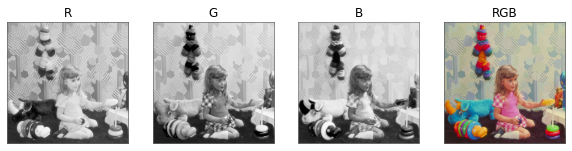

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for idx, (ax, band) in enumerate(zip(axs, ['r', 'g', 'b'])):
    ax.imshow(girl_img[:,:,idx])
    ax.set_title(band.capitalize())
    ax.axis('off')
axs[3].imshow(girl_img)
axs[3].set_title('RGB')
axs[3].axis('off')
plt.show()

We define a function to convert an rgb (3-band) image to a single-band greyscale one. The function is based on Matlab's `greyscale` function.

In [6]:
def rgb2grey(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  grey = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return grey

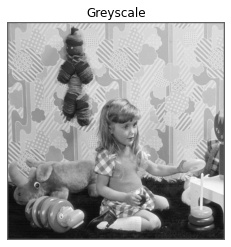

In [7]:
girl_grey = rgb2grey(girl_img)
plt.axis("off")
plt.title("Greyscale")
plt.imshow(girl_grey)

Opening and reviewing the other two images quickly:

(512, 512, 3)
<class 'numpy.ndarray'>
(512, 512, 3)
<class 'numpy.ndarray'>


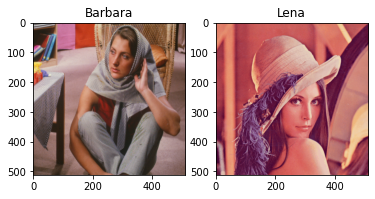

In [8]:
barb_img = loadImage('barbara.bmp')
lena_img = loadImage('lena.bmp')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(barb_img)
axs[0].set_title('Barbara')
axs[1].imshow(lena_img)
axs[1].set_title('Lena')
plt.show()

## Transformation Matrix

(956, 964, 3)
<class 'numpy.ndarray'>


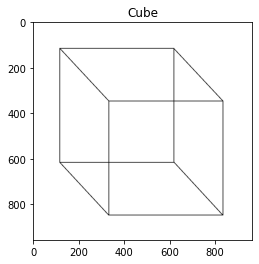

In [9]:
cube = loadImage('Cube.png')
plt.title('Cube')
plt.imshow(cube)

In [156]:
T = np.array([[1, 1, 0],[0,1,0],[0,0,1]])
girl_transformed = np.zeros((1024, 1024, 3), dtype=np.uint8)

for i, row in enumerate(girl_img):
  for j, col in enumerate(row):
    pixel_data = girl_img[i, j, :]
    input_coords = np.array([i, j, 1])
    i_out, j_out, _ = T @ input_coords
    girl_transformed[i_out, j_out, :] = pixel_data

plt.imshow(girl_transformed)

IndexError: ignored

But we need to scale the transformeed image to fit on the Cube, hence we define a `scale` function.

In [11]:
# image img to be scaled to nr × nc
def scale(img, nr, nc):
  nr0 = len(img)     # source number of rows 
  nc0 = len(img[0])  # source number of columns 
  return [[ img[int(nr0 * r / nr)][int(nc0 * c / nc)]  
             for c in range(nc)] for r in range(nr)]

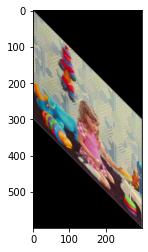

In [147]:
girl_scaled = scale(girl_transformed, 600, 300)
plt.imshow(girl_scaled)

In [148]:
girl_scaled = np.asarray(girl_scaled)
print(type(girl_scaled))
print(girl_scaled.shape)

<class 'numpy.ndarray'>
(600, 300, 3)


(600, 300, 3)


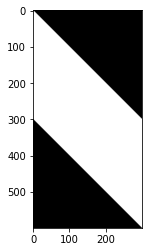

In [149]:
mask = (girl_scaled != [0,0,0]).all(-1)
plt.imshow(mask)
mask = np.dstack([mask]*3)
print(mask.shape)

Expand the image using paddings to fit on Cube image for masking purposes. We can modify the `extra_left`, `extra_right`, `extra_top` and `extra_bottom` parameters to transform the image on the spatial plane so it can fit on the sides.

In [150]:
extra_left, extra_right = [50, (cube.shape[0] - mask.shape[0])-50]
extra_top, extra_bottom = [50, (cube.shape[1] - mask.shape[1])-50]
# expand image canvases for masking
masked = np.pad(mask, ((extra_left, extra_right), (extra_top, extra_bottom), (0, 0)),
       mode='constant', constant_values=0)
girl_modified = np.pad(girl_scaled,((extra_left, extra_right), (extra_top, extra_bottom), (0, 0)),
       mode='constant', constant_values=0)

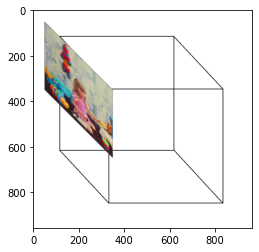

In [151]:
cubed = np.copy(cube)
# the cube elements are of type float
cubed = (cubed*255).astype(np.uint8)
idx=(masked!=0)
cubed[idx]=girl_modified[idx]
plt.imshow(cubed)